In [71]:
from __future__ import division
import numpy as np
import sys

In [79]:
import librosa
x, sr = librosa.load('bensound-happyrock.mp3')

In [16]:
print(x.shape)
print(sr)

(2333952,)
22050


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

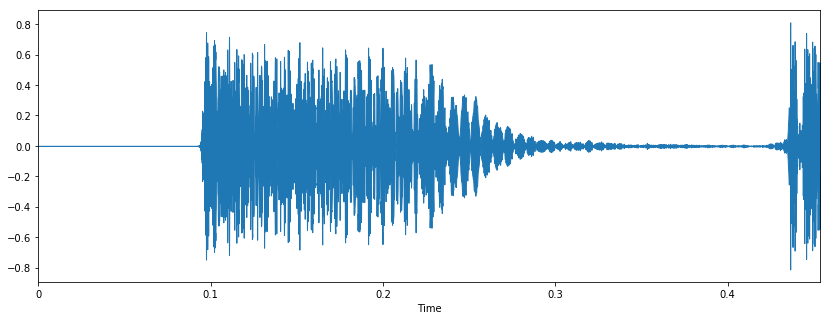

In [18]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x[:10000], sr=sr)

In [80]:
X = (x - min(x))/(max(x)-min(x))

In [81]:
q = 1/256
y = q * np.round(X/q)

In [55]:
a=np.unique(y)

In [56]:
a.shape

(254,)

In [35]:
import IPython.display as ipd
ipd.Audio(y, rate=sr) # load a local WAV file

In [34]:
a

array([0.        , 0.00390625, 0.0078125 , 0.01171875, 0.015625  ,
       0.01953125, 0.0234375 , 0.02734375, 0.03125   , 0.03515625,
       0.0390625 , 0.04296875, 0.046875  , 0.05078125, 0.0546875 ,
       0.05859375, 0.0625    , 0.06640625, 0.0703125 , 0.07421875,
       0.078125  , 0.08203125, 0.0859375 , 0.08984375, 0.09375   ,
       0.09765625, 0.1015625 , 0.10546875, 0.109375  , 0.11328125,
       0.1171875 , 0.12109375, 0.125     , 0.12890625, 0.1328125 ,
       0.13671875, 0.140625  , 0.14453125, 0.1484375 , 0.15234375,
       0.15625   , 0.16015625, 0.1640625 , 0.16796875, 0.171875  ,
       0.17578125, 0.1796875 , 0.18359375, 0.1875    , 0.19140625,
       0.1953125 , 0.19921875, 0.203125  , 0.20703125, 0.2109375 ,
       0.21484375, 0.21875   , 0.22265625, 0.2265625 , 0.23046875,
       0.234375  , 0.23828125, 0.2421875 , 0.24609375, 0.25      ,
       0.25390625, 0.2578125 , 0.26171875, 0.265625  , 0.26953125,
       0.2734375 , 0.27734375, 0.28125   , 0.28515625, 0.28906

In [39]:
c = np.zeros(y.shape[0])
for i in range(y.shape[0]):
    c[i] = np.nonzero(a==y[i])[0]
c = c.astype(int)

In [45]:
c.shape

(2333952,)

In [61]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 60
dataX = []
dataY = []
n_chars = 200000#c.shape[0]
for i in range(0, n_chars - seq_length, 3):
    seq_in = c[i:i + seq_length]
    seq_out = c[i + seq_length]
    dataX.append(seq_in)
    dataY.append(seq_out)
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

('Total Patterns: ', 66647)


In [62]:
from keras.utils import np_utils
n_vocab = a.shape[0]
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY, num_classes=n_vocab)

In [58]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

In [63]:
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [64]:
model.fit(X, y, epochs=20, batch_size=128)

Epoch 1/20
66647/66647 [==============================] - 110s 2ms/step - loss: 4.8594
Epoch 2/20
66647/66647 [==============================] - 111s 2ms/step - loss: 4.2687
Epoch 3/20
66647/66647 [==============================] - 113s 2ms/step - loss: 4.0353
Epoch 4/20
66647/66647 [==============================] - 119s 2ms/step - loss: 3.8919
Epoch 5/20
66647/66647 [==============================] - 124s 2ms/step - loss: 3.7977
Epoch 6/20
66647/66647 [==============================] - 133s 2ms/step - loss: 3.7191
Epoch 7/20
66647/66647 [==============================] - 126s 2ms/step - loss: 3.6735
Epoch 8/20
66647/66647 [==============================] - 131s 2ms/step - loss: 3.6039
Epoch 9/20
66647/66647 [==============================] - 133s 2ms/step - loss: 3.5567
Epoch 10/20
66647/66647 [==============================] - 132s 2ms/step - loss: 3.5161
Epoch 11/20
66647/66647 [==============================] - 132s 2ms/step - loss: 3.4876
Epoch 12/20
66647/66647 [================

In [65]:
# serialize model to JSON
model_json = model.to_json()
with open("modelgenMusicLSTM.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelgenMusicLSTM.h5")
print("Saved model to disk")

Saved model to disk


In [66]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
# pick a random seed
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Seed:")
print(pattern)
seq_out = []
# generate characters
for i in range(200000):
    x = np.reshape(pattern, (1, seq_length, 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)[0]
    index = sample(prediction, 0.3)
    result = a[index]
    #sys.stdout.write(result)
    seq_out.append(result)
    pattern = np.r_[pattern[1:len(pattern)],index]
    #pattern = pattern[1:len(pattern)]
print("\nDone.")

Seed:
[131 110  97  93  97 110 132 155 166 158 131  89  50  33  37  55  72  79
  82  87  92  90  78  63  54  53  60  73  89 105 115 117 111 100  90  86
  87  92 101 111 115 115 114 117 120 120 116 112 112 117 124 128 127 124
 121 119 120 123 127 130]


In [75]:
seq_out = np.array(seq_out)
seq_out.shape

(10000,)

In [76]:
seq_out[:10]

array([0.42578125, 0.44921875, 0.44921875, 0.44921875, 0.4609375 ,
       0.4609375 , 0.47265625, 0.4609375 , 0.47265625, 0.47265625],
      dtype=float32)

In [77]:
ipd.Audio(seq_out, rate=sr) # load a local WAV file

In [82]:
ipd.Audio(y[:200000], rate=sr) # load a local WAV file

In [ ]:
librosa.output.write_wav('Generated.wav', seq_out, sr)